In [1]:
import pandas as pd
import os
import numpy as np

os.environ["SPARK_HOME"] = "/Users/admin/Personal/Code/spark-3.5.0-bin-hadoop3"
# os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
# os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

conf = SparkConf()
# conf.set("spark.pyspark.python", "/usr/bin/python3")
# conf.set("spark.pyspark.driver.python", "/usr/bin/python3")
conf.set("spark.driver.memory", "6g")
conf.set("spark.executor.memory", "6g")

spark = SparkSession.builder \
    .master("local[6]") \
    .config(conf=conf) \
    .appName("audio-classification") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/06 07:09:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [103]:
pd_df = pd.read_pickle('./data/dataframe-16k.pkl')
# pd_df['id'] = range(len(pd_df))
# pd_df.reset_index(inplace=True, drop=True)
len(pd_df)

15950

In [7]:
rows_with_nan = pd_df[pd_df.isna().any(axis=1)]
rows_with_nan

,audio_file_path,filename,original_duration,rms,category,log_attack_time,temporal_centroid,temporal_centroid_duration,lat_tc_ratio,release,...,mfcc_9_loudest,mfcc_9_d_mean,mfcc_10_mean,mfcc_10_loudest,mfcc_10_d_mean,mfcc_11_mean,mfcc_11_loudest,mfcc_11_d_mean,start_time,end_time
68,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Snow Lefty Tom,0.594104,0.242114,tom,-1.634139,0.240926,4096,-6.782741,3072,...,53.572746,-1.800732,25.843645,51.657692,-1.592103,25.008400,49.527603,-1.366670,0.002698,NaN
69,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Snow Right Tom,0.594104,0.237975,tom,-1.634139,0.253551,3584,-6.445012,2560,...,53.811996,-3.928532,25.452454,51.614391,-3.467546,24.595579,49.656677,-3.056485,0.000000,NaN
70,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Snow Wide Snap,0.594104,0.027316,snap,-1.634139,0.340621,2048,-4.797529,1024,...,0.552055,-0.338946,0.591699,0.191097,-0.801205,-1.112846,-1.213948,-0.202205,0.002698,NaN
71,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Snow Smash Crowd Clap,0.594104,0.132822,clap,-1.333109,0.353951,3584,-3.766360,2048,...,-13.826558,1.935609,-7.985457,-15.961778,0.464811,-8.623932,-16.288651,-0.914339,0.000000,NaN
72,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,Snow Turn Apart Snare,0.891111,0.280217,snare,-1.634139,0.124075,8192,-13.170521,7168,...,47.428493,-0.889117,13.846289,44.404247,-0.643916,12.976629,42.350506,-0.504203,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14892,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,OS_EVG_Snare_Delicacy,0.666531,0.104149,snare,-1.935169,0.207889,2048,-9.308663,1536,...,-1.751744,1.558224,-3.661452,-3.680326,0.093050,-1.611243,-1.080148,-0.543850,0.000000,NaN
14893,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,OS_EVG_Snare_Vintage,0.749524,0.183144,snare,-1.634139,0.143004,3584,-11.427205,2560,...,30.676586,-5.271332,13.142733,24.309925,-4.158367,10.507173,18.833158,-3.666605,0.000000,NaN
14894,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,OS_EVG_Snare_Vintage Era,1.024580,0.166364,snare,-1.333109,0.280136,3584,-4.758789,2048,...,0.149360,6.519796,-9.343969,-4.653327,5.360568,-9.463795,-8.902809,3.885331,0.000000,NaN
14895,/Volumes/Samsung SSD 980 PRO 2TB/Sample Packs/...,OS_EVG_Snare_Fuzz,0.524535,0.174912,snare,-1.634139,0.240393,2560,-6.797766,1536,...,24.570076,-4.064134,10.750495,21.255974,-3.897069,10.320130,20.453928,-3.709387,0.000000,NaN


In [105]:
from pyspark.sql.functions import count, desc

spark_df = spark.createDataFrame(pd_df)

spark_df.groupBy('category').count().orderBy(desc('count')).show()

+--------+-----+
|category|count|
+--------+-----+
|   snare| 4615|
|    kick| 3578|
|    clap| 2324|
|  hi-hat| 1839|
|     tom|  682|
|   crash|  584|
|open-hat|  576|
|  shaker|  494|
|    snap|  421|
|    ride|  321|
|     rim|  296|
|   bongo|  220|
+--------+-----+



In [106]:
from sklearn.model_selection import train_test_split

string_columns = ['audio_file_path', 'filename', 'category']
numeric_columns = [col for col in list(spark_df.columns) if col not in string_columns]
# train_df, test_df = spark_df.randomSplit([0.7,0.3], seed=4000)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)
# spark_df.show(1)

In [107]:
from pyspark.ml.feature import Imputer

imputer = Imputer()
imputed_columns = [f'imp_{col}' for col in numeric_columns]
imputer.setInputCols(numeric_columns)
imputer.setOutputCols(imputed_columns)
imputer_model = imputer.fit(spark_df)
imputed_df = imputer_model.transform(spark_df)
# imputer.fit(train_df)
# train_df = imputer.transform(train_df)
# rows_with_nan = train_df[train_df.isna().any(axis=1)]
# rows_with_nan
# imputed_df.show(1)

In [108]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=imputed_columns, outputCol='features')
assembled_df = assembler.transform(imputed_df)


standard_scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaled_df = standard_scaler.fit(assembled_df).transform(assembled_df)
# scaled_df

In [109]:
from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCol="category", outputCol="label")
string_indexer_model = string_indexer.fit(scaled_df)
indexed_df = string_indexer_model.transform(scaled_df)
indexed_df.columns

['audio_file_path',
 'filename',
 'original_duration',
 'rms',
 'category',
 'log_attack_time',
 'temporal_centroid',
 'temporal_centroid_duration',
 'lat_tc_ratio',
 'release',
 'g_mean_rms',
 'g_std_rms',
 'g_zcr_rms',
 'mean_rms',
 'std_rms',
 'max_rms',
 'mean_zcr',
 'std_zcr',
 'zcr_at_rms_peak',
 'crest_factor',
 'log_spec_cent_mean',
 'log_spec_cent_std',
 'log_spec_cent_peak',
 'log_spec_cent_g_mean',
 'leg_spec_cent_g_std',
 'log_spec_cent_g_zcr',
 'spec_band_mean',
 'spec_band_std',
 'spec_band_peak',
 'spec_band_g_mean',
 'spec_flat_mean',
 'spec_flat_max',
 'spec_flat_min',
 'spec_flat_std',
 'spec_flat_peak',
 'log_spec_rolloff_15_peak',
 'log_spec_rolloff_15_max',
 'log_spec_rolloff_15_min',
 'log_spec_rolloff_85_peak',
 'log_spec_rolloff_85_max',
 'log_spec_rolloff_85_min',
 'mfcc_0_mean',
 'mfcc_0_loudest',
 'mfcc_0_d_mean',
 'mfcc_1_mean',
 'mfcc_1_loudest',
 'mfcc_1_d_mean',
 'mfcc_2_mean',
 'mfcc_2_loudest',
 'mfcc_2_d_mean',
 'mfcc_3_mean',
 'mfcc_3_loudest',
 'mfcc

In [110]:
train_df, test_df = indexed_df.randomSplit([0.7,0.3])
# train_df.columns

In [111]:
from pyspark.ml.classification import RandomForestClassifier

forest_classifier = RandomForestClassifier(numTrees=400, minInstancesPerNode=2, featuresCol='scaled_features', labelCol='label')
fc_model = forest_classifier.fit(train_df)

In [112]:
fc_predictions_df = fc_model.transform(test_df)
# fc_predictions_df.columns

In [128]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(fc_predictions_df)
accuracy

0.7068965517241379

In [49]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html
# Doesn't support multiclass labels
# from pyspark.ml.classification import GBTClassifier

# gbtc_classifier = GBTClassifier(maxIter=20, minInstancesPerNode=2, featuresCol='scaled_features', labelCol='label')
# gbtc_model = gbtc_classifier.fit(train_df)

24/01/06 02:19:05 ERROR Executor: Exception in task 0.0 in stage 172.0 (TID 631)
java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 2.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.colle

Py4JJavaError: An error occurred while calling o1203.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 172.0 failed 1 times, most recent failure: Lost task 4.0 in stage 172.0 (TID 635) (dmitrys-mbp.home executor driver): java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 2.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1223)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2492)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$1(RDD.scala:1225)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.aggregate(RDD.scala:1218)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:125)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:333)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:61)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$1(GBTClassifier.scala:201)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:170)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:58)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 2.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1223)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2492)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more


In [121]:
from pyspark.sql.functions import col, when, sum, count, desc
from pyspark.ml.feature import IndexToString

label_converter = IndexToString(inputCol="prediction", outputCol="prediction_label", labels=string_indexer_model.labels)

predictions_with_labels = label_converter.transform(fc_predictions_df)
predictions_with_labels.select(['prediction_label']).show(3)

predictions_with_accuracy = predictions_with_labels.withColumn(
    "is_correct",
    when(col("prediction_label") == col("category"), 1).otherwise(0)
)

accuracy_per_category = (predictions_with_accuracy.groupBy("category")
                         .agg(
                             (sum("is_correct") / count("is_correct")).alias("accuracy"))
                         .orderBy(desc('accuracy')))
apc_df = accuracy_per_category.toPandas()

category_counts_df = pd_df['category'].value_counts().reset_index()
category_counts_df.columns = ['category', 'count']


merged_df = category_counts_df.merge(apc_df, on='category')

merged_df

+----------------+
|prediction_label|
+----------------+
|           snare|
|           snare|
|           snare|
+----------------+
only showing top 3 rows



,category,count,accuracy
0,snare,4615,0.800422
1,kick,3578,0.973758
2,clap,2324,0.722380
3,hi-hat,1839,0.829604
4,tom,682,0.522167
5,crash,584,0.634483
6,open-hat,576,0.000000
7,shaker,494,0.213333
8,snap,421,0.023810
9,ride,321,0.000000


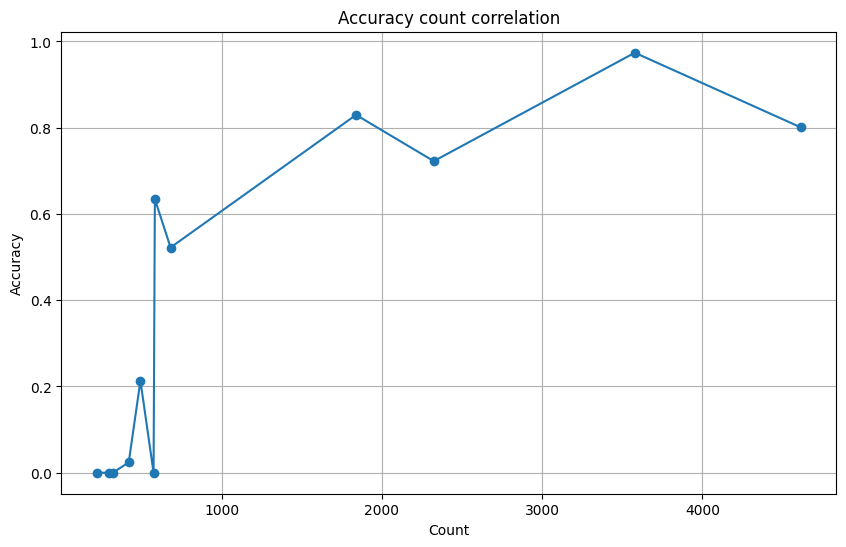

In [124]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['count'], merged_df['accuracy'], marker='o')

plt.xlabel('Count')
plt.ylabel('Accuracy')
plt.title('Accuracy count correlation')
plt.grid(True)

# Show the plot
plt.show()

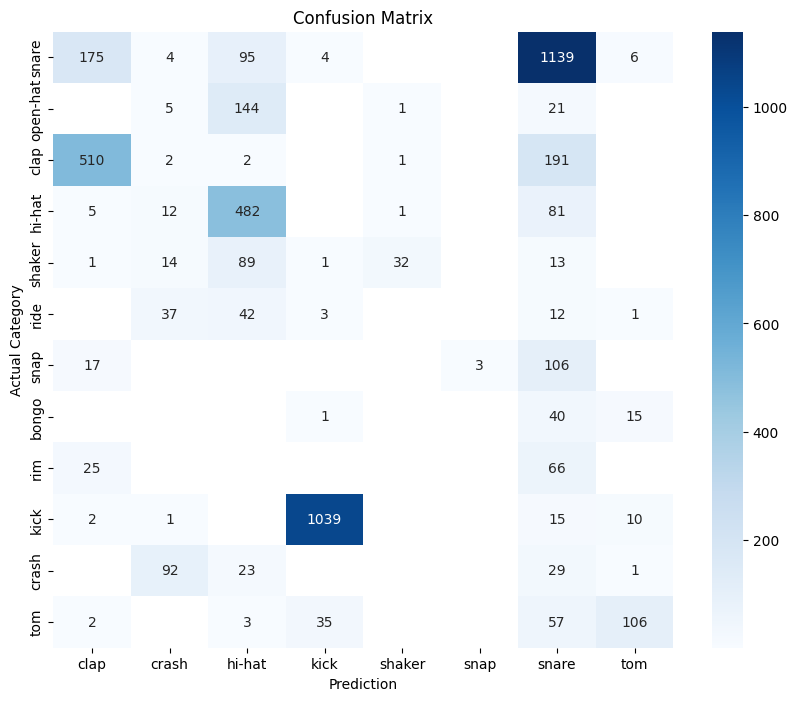

In [125]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix_df = (predictions_with_labels
                       .groupBy("category")
                       .pivot("prediction_label")
                       .count())
confusion_matrix_pd = confusion_matrix_df.toPandas()
confusion_matrix_pd = confusion_matrix_pd.set_index("category")

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_pd, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Category')
plt.xlabel('Prediction')
plt.show()

In [126]:
from pyspark.ml.classification import RandomForestClassifier

importances = fc_model.featureImportances
importances_list = importances.toArray().tolist()

feature_importance_df = pd.DataFrame(list(zip(numeric_columns, importances_list)),
                                     columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

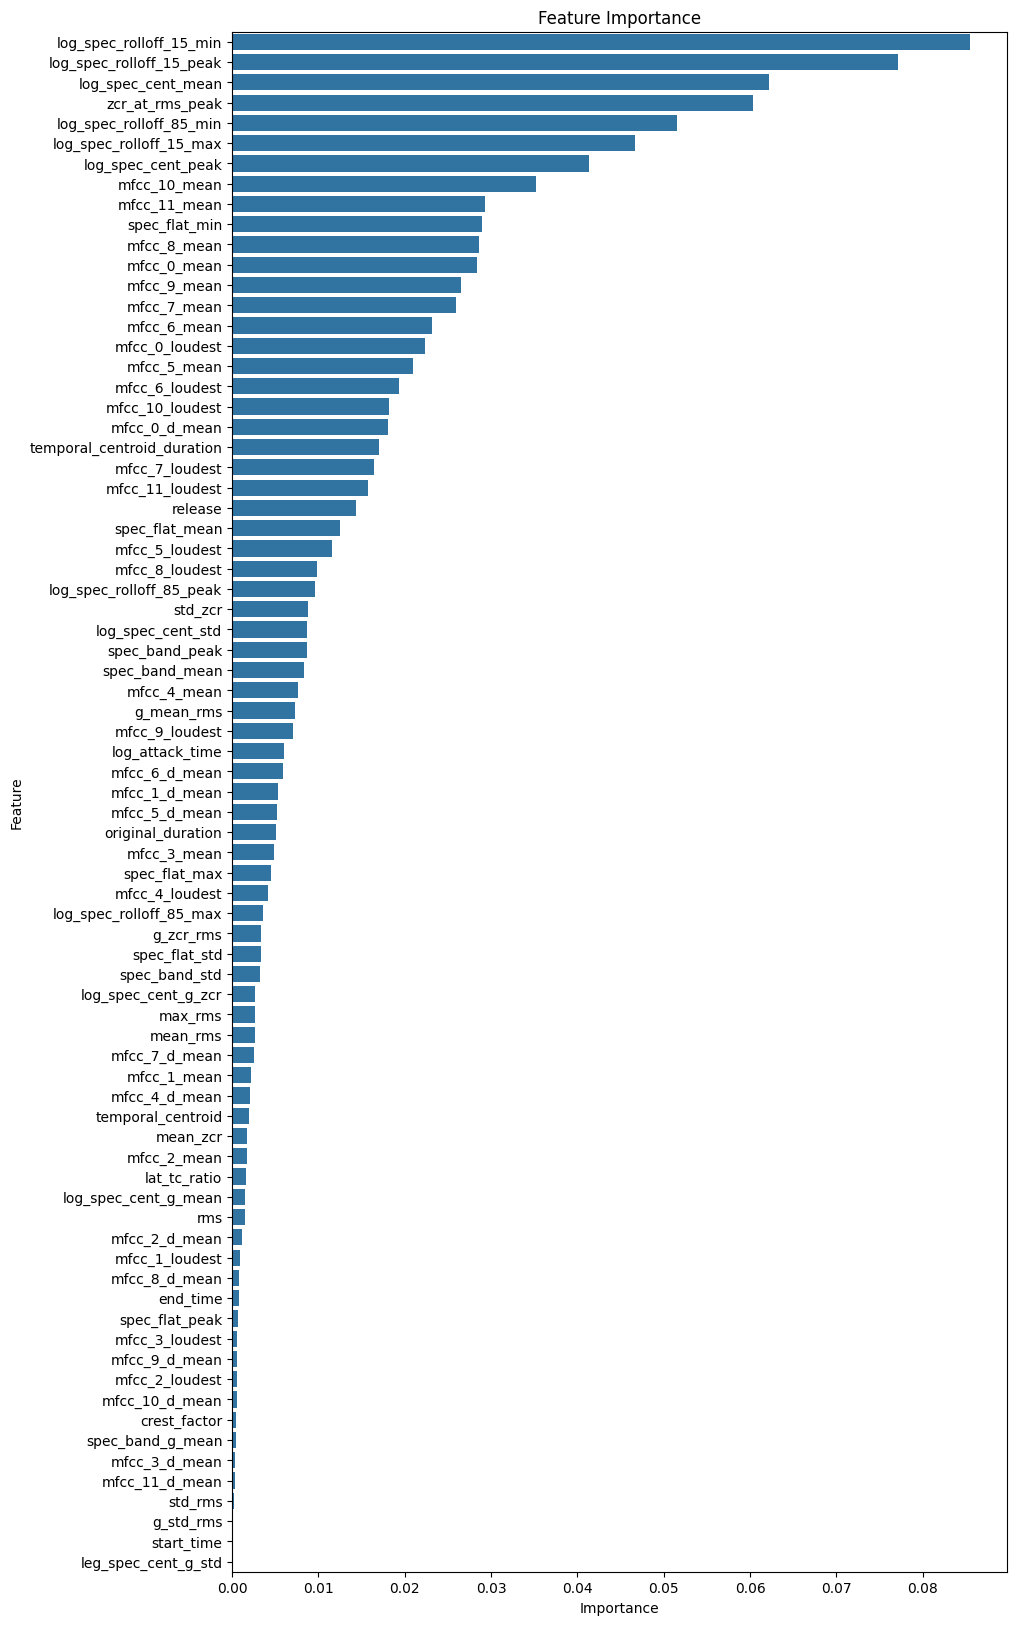

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 20))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()